## Load libraries

In [1]:
library(tidyverse)
library(anomalize)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Load the Data

In [482]:
tb = read_csv("../../output/NYCHA_TS.csv")
tb = select(tb, c('Building_Meter', 'Month', 'Imputed_KWH'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Building_Meter = col_character(),
  Month = col_date(format = ""),
  Month_Type = col_character(),
  `Month_#_Days` = col_double(),
  Prorated_Days = col_double(),
  Gap_Days = col_double(),
  Gap_Type = col_character(),
  Prorated_KWH = col_double(),
  Imputed_KWH = col_double()
)


## Explore the Anomalize package

#### plotting configuration for the flagged anomalies

In [337]:
# ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

### Example 1 - Account with no missing data

#### Method 1: STL + IQR

In [346]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

ts_anomalized$Month_Value = format(ts_anomalized$Month,"%m")

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [347]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2,Month_Value
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12265.34,150984.3,-56008.64,-23528,23388.25,Yes,115190.9,162107.2,11
165.0 - BLD 03_90327795,2014-07-01,177073.8,177073.8,49841.16,153031.5,-25798.86,-23528,23388.25,Yes,179344.6,226260.9,07
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,34686.26,156279.1,31064.60,-23528,23388.25,Yes,167437.4,214353.7,08


#### Plot the decomposed results with outliers

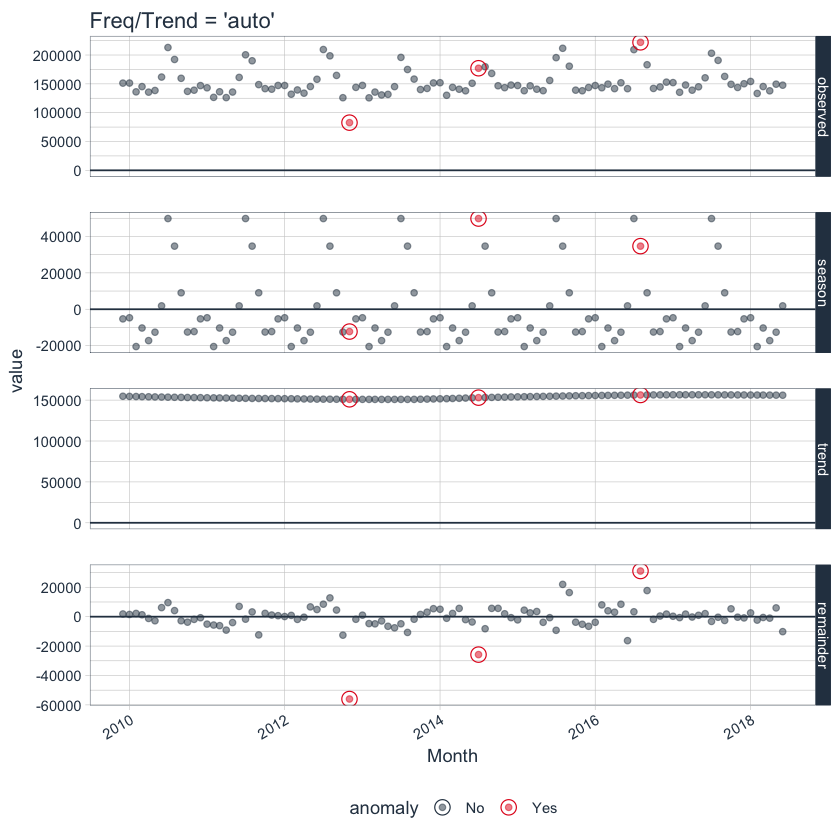

In [88]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### Plot the anomalies by its rank of deviation

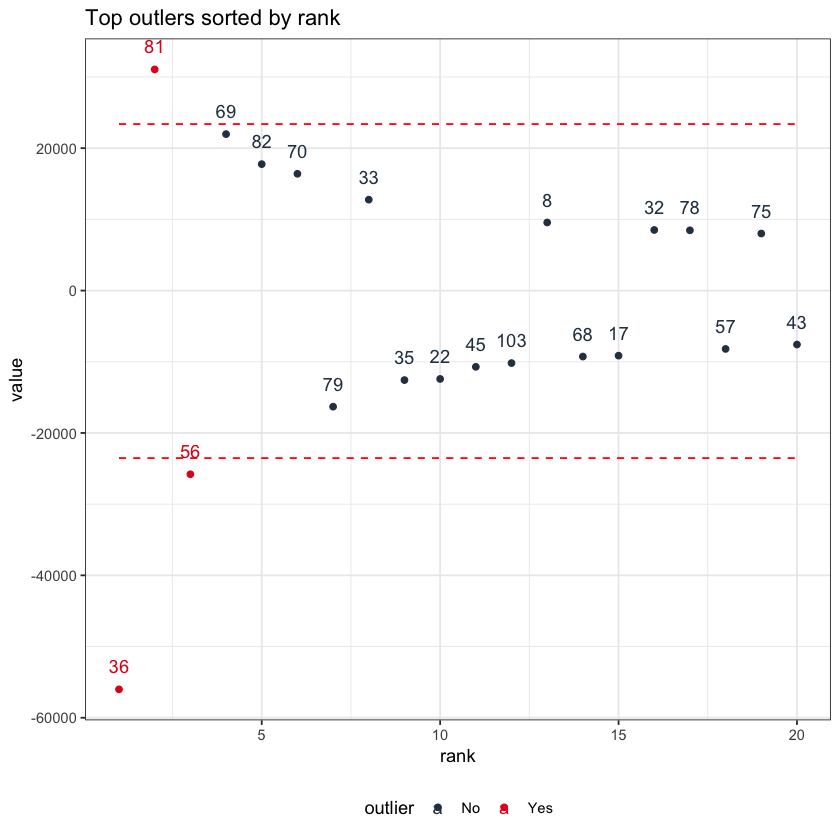

In [340]:
outliers <- iqr(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Top outlers sorted by rank") 

#### Method 2: Twitter + GESD

In [348]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


The Twitter decomposition method returns more outilers than the original STL method.

In [349]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,median_spans,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12508.822,144548.5,-49329.365,-7960.897,7960.897,Yes,124078.8,140000.6
165.0 - BLD 03_90327795,2013-08-01,174890.0,174890.0,39178.342,144548.5,-8836.832,-7960.897,7960.897,Yes,175765.9,191687.7
165.0 - BLD 03_90327795,2014-07-01,177073.8,177073.8,49199.121,147692.3,-19817.651,-7960.897,7960.897,Yes,188930.5,204852.3
165.0 - BLD 03_90327795,2016-06-01,141632.4,141632.4,2482.649,147692.3,-8542.575,-7960.897,7960.897,Yes,142214.1,158135.9
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,39178.342,147692.3,35159.351,-7960.897,7960.897,Yes,178909.8,194831.5
165.0 - BLD 03_90327795,2016-09-01,183134.8,183134.8,8316.164,147692.3,27126.328,-7960.897,7960.897,Yes,148047.6,163969.4


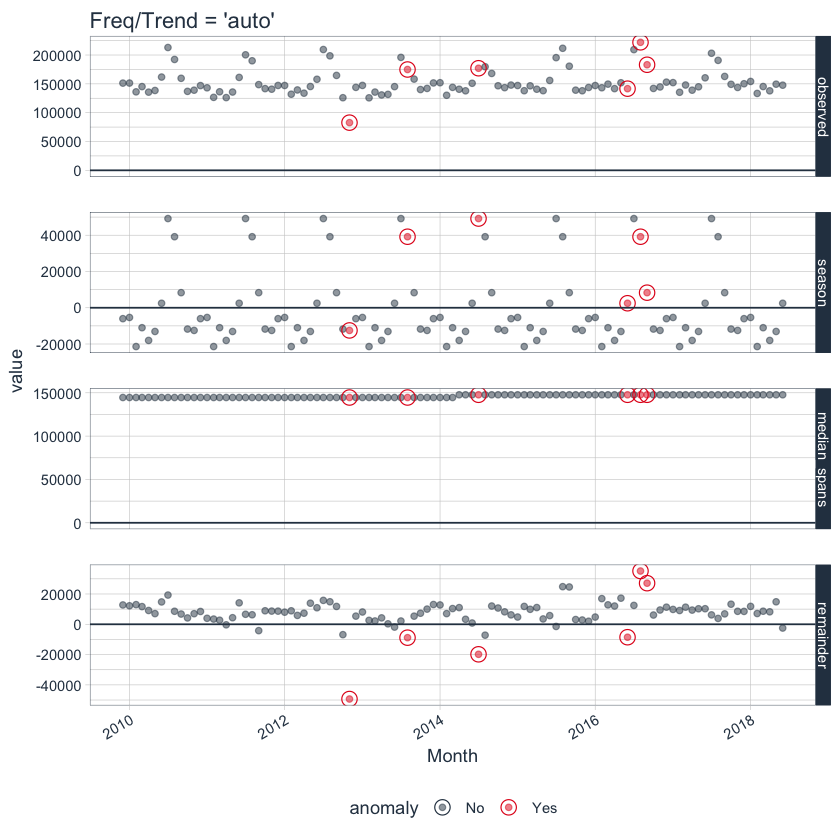

In [344]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### Plot the anomalies by its rank of deviation

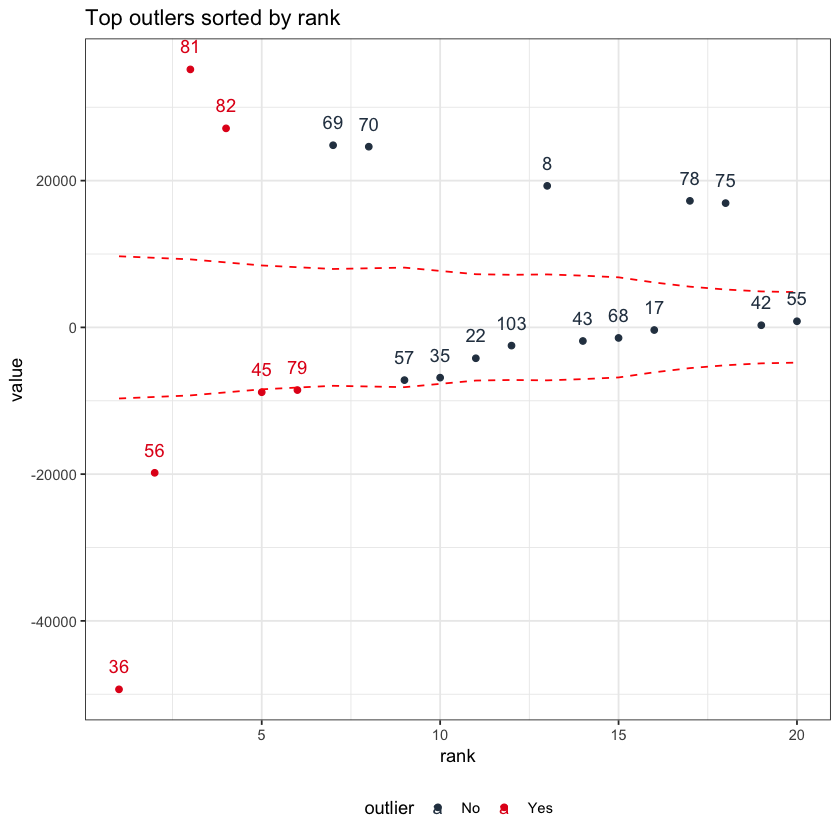

In [345]:
outliers <- gesd(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Top outlers sorted by rank") 

### Adjust the max_anoms parameter

#### STL + IQR

In [17]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', max_anoms = (sum(ts$Imputed_KWH == 0) + 2)/nrow(ts)) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


By specifying the max number of outliers allowed, we get exactly the amount of outliers specified. The algorithm returns data points that have the largest absolute deviations in the residual component. 

In [19]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12265.34,150984.3,-56008.64,-23528,23388.25,Yes,115190.9,162107.2
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,34686.26,156279.1,31064.60,-23528,23388.25,Yes,167437.4,214353.7


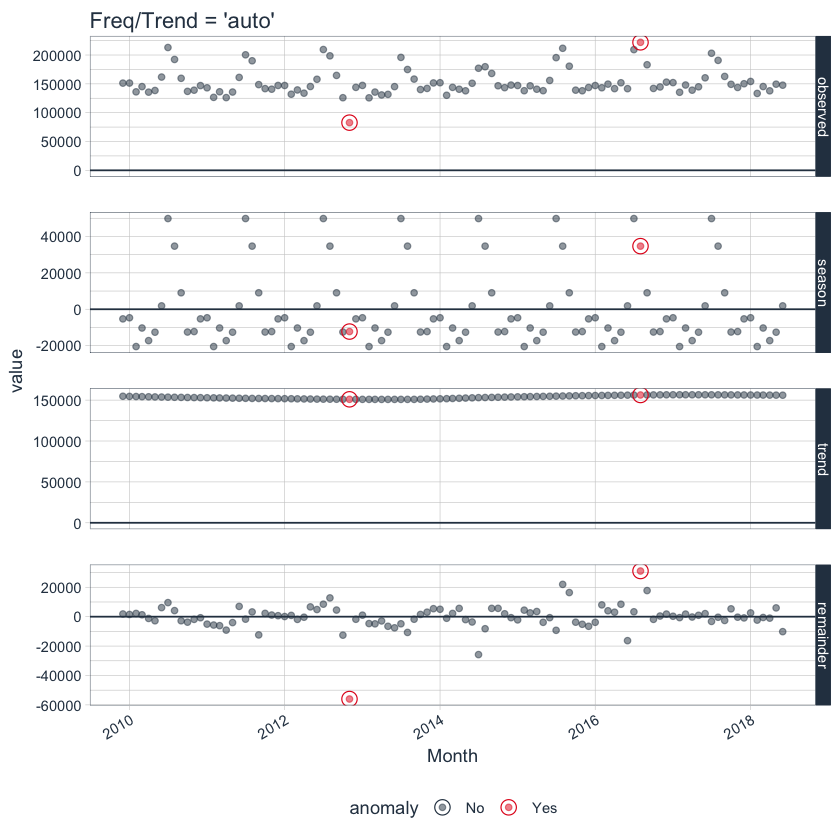

In [21]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

### Example 2 - Account with three missing values in the middle

#### Method: STL + IQR

In [247]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = 'stl', merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [248]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
164.0 - BLD 01_96973681,2012-11-01,64020.36,6.402036e+04,-3596.0013,97378.53,-29762.17,-23658.08,23760.54,Yes,70124.45,117543.1
164.0 - BLD 01_96973681,2013-01-01,0.00,-6.366463e-12,447.0866,97336.85,-97783.94,-23658.08,23760.54,Yes,74125.86,121544.5
164.0 - BLD 01_96973681,2013-02-01,0.00,1.818989e-12,-11446.9268,97316.01,-85869.08,-23658.08,23760.54,Yes,62211.00,109629.6
164.0 - BLD 01_96973681,2013-03-01,0.00,2.728484e-12,-5029.7667,97295.17,-92265.40,-23658.08,23760.54,Yes,68607.32,116025.9


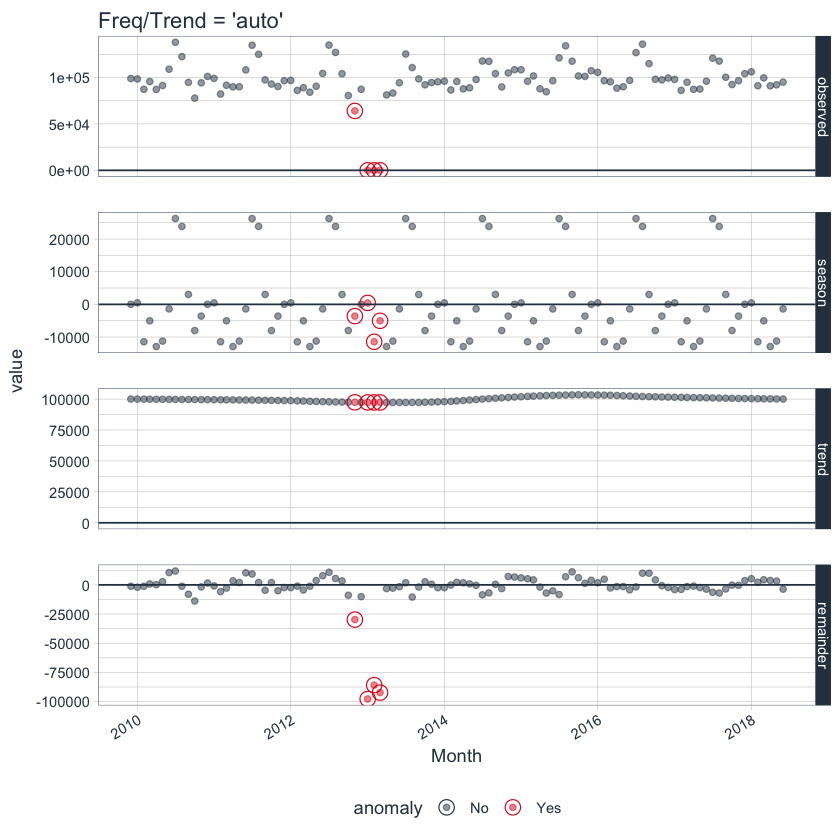

In [250]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### Method: Twitter + GESD

In [251]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = 'twitter', merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


In [252]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,median_spans,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
164.0 - BLD 01_96973681,2012-11-01,64020.36,6.402036e+04,-3732.39396,94440,-26687.24,-12767.11,12767.11,Yes,77940.50,103474.71
164.0 - BLD 01_96973681,2013-01-01,0.00,1.918465e-12,78.54968,94440,-94518.55,-12767.11,12767.11,Yes,81751.44,107285.66
164.0 - BLD 01_96973681,2013-02-01,0.00,1.818989e-12,-11921.57764,94440,-82518.42,-12767.11,12767.11,Yes,69751.31,95285.53
164.0 - BLD 01_96973681,2013-03-01,0.00,9.094947e-13,-5461.12432,94440,-88978.88,-12767.11,12767.11,Yes,76211.77,101745.98


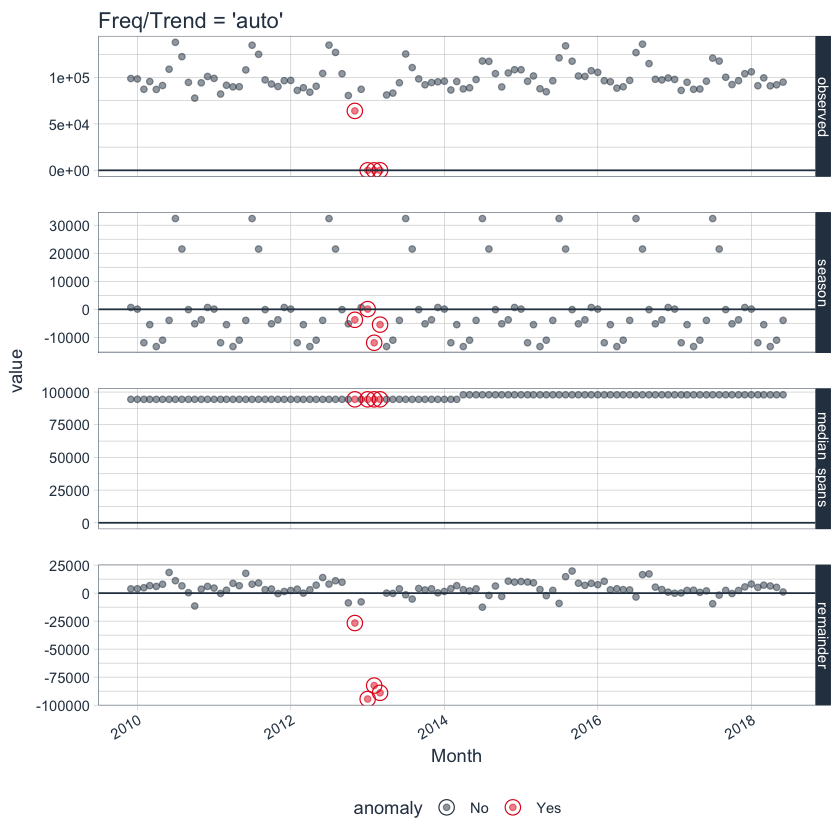

In [253]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

## Loop through all accounts (with at least 3 years of data)

We can do the following parameters tuning for each account:
- Twitter vs. STL decomposition method
- IQR vs. GESD test on residuals
- max_anom for the upper limit of number of outliers
- others

For now, we just use the default setting and same parameter configurations for all accounts.

Only consider accounts with more than 3 years of data

In [486]:
accounts = tb %>% group_by(Building_Meter) %>% summarise(counts = n())
accounts = filter(accounts, counts >= 36)$Building_Meter

length(accounts)

[1] 2310

#### STL + IQR method

In [491]:
results_stl <- vector("list", length(accounts)) 

start.time <- Sys.time()

for (i in 1:length(accounts)) {
# for (i in 1:2) {
    ts = select(filter(tb, Building_Meter == accounts[[i]]), 'Month', 'Imputed_KWH')
    num_zeros = sum(ts$Imputed_KWH == 0)
    ts_anomalized <- ts %>%
        time_decompose(Imputed_KWH, merge = TRUE, method = 'stl') %>%
        anomalize(remainder, method = 'iqr', max_anom = ((nrow(ts) - num_zeros) * 0.2 + num_zeros)/(nrow(ts))) %>%
#         anomalize(remainder) %>%
        time_recompose()
    ts_anomalized$Account = accounts[[i]]
    results[[i]] <- ts_anomalized
}

end.time <- Sys.time()
time.taken <- end.time - start.time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting

frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 24.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 35.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converti

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11 months
trend = 11 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23.5 months


frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

trend = 29.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 29.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 6 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 8 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 

trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 8 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Convert

frequency = 12 months
trend = 31 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 33 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 21 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 21 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 27.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 35 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 23 months
Converting

frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 8 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converti

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 27 months
Converting

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 47 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Conver

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting

frequency = 12 months
trend = 30.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index 

trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend 

frequency = 12 months
trend = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 20.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 19 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequenc

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Conver

frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 22.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 22.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 22.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 4 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 4 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 4 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequen

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30.5 months


In [492]:
time.taken

Time difference of 3.335243 mins

##### Summary of the % of anomalies detected

In [493]:
points = lapply(results, function(i) nrow(i))
anoamly_counts = lapply(results, function(i) nrow(filter(i, anomaly == 'Yes')))

In [494]:
summary_stl = tibble('points' = unlist(points), 'anomalies' = unlist(anoamly_counts))
summary_stl = mutate(summary, perc = anomalies / points)
summary(summary_stl$perc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02913 0.07767 0.08853 0.13592 0.42222 

#### Twitter + GESD method

In [487]:
results_twitter <- vector("list", length(accounts)) 

start.time <- Sys.time()

for (i in 1:length(accounts)) {
# for (i in 1:2) {
    ts = select(filter(tb, Building_Meter == accounts[[i]]), 'Month', 'Imputed_KWH')
    num_zeros = sum(ts$Imputed_KWH == 0)
    ts_anomalized <- ts %>%
        time_decompose(Imputed_KWH, merge = TRUE, method = 'twitter') %>%
        anomalize(remainder, method = 'gesd', max_anom = ((nrow(ts) - num_zeros) * 0.2 + num_zeros)/(nrow(ts))) %>%
#         anomalize(remainder) %>%
        time_recompose()
    ts_anomalized$Account = accounts[[i]]
    results[[i]] <- ts_anomalized
    cat(i)
}

end.time <- Sys.time()
time.taken <- end.time - start.time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


3

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


4

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


5

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


6

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


7

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


8

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


9

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


10

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


11

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


12

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


13

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


14

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 102 months


15

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


16

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


17

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


18

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


19

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


20

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


21

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


22

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


23

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


24

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


25

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


26

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


27

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


28

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


29

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10 months


30

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


31

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


32

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


33

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


34

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


35

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24 months


36

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


37

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


38

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


39

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


40

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


41

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


42

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


43

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


44

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


45

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


46

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


47

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


48

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


49

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


50

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


51

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


52

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


53

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


54

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


55

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


56

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


57

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


58

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


59

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


60

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25.5 months


61

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


62

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


63

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


64

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


65

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 9 months


66

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


67

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


68

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


69

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


70

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


71

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


72

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


73

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


74

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


75

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


76

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


77

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


78

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


79

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


80

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


81

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


82

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


83

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


84

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


85

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24 months


86

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


87

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


88

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


89

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


90

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


91

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


92

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


93

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


94

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


95

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


96

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


97

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


98

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


99

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


100

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


101

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


102

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


103

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


104

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


105

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


106

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


107

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


108

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


109

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


110

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


111

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


112

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


113

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


114

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


115

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


116

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


117

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 5 months


118

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 9.5 months
median_span = 9 months


119

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


120

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


121

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


122

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


123

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


124

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


125

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


126

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


127

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


128

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


129

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


130

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


131

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


132

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


133

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


134

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


135

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


136

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


137

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


138

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


139

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


140

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40 months


141

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


142

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40 months


143

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


144

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


145

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


146

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


147

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


148

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


149

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


150

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


151

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


152

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months


153

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


154

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


155

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24.5 months


156

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


157

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


158

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


159

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


160

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


161

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


162

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


163

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


164

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 14 months


165

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


166

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


167

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


168

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


169

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


170

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


171

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


172

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


173

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


174

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


175

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


176

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


177

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


178

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


179

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


180

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


181

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


182

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


183

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


184

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


185

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


186

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


187

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


188

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


189

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


190

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


191

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


192

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


193

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


194

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


195

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


196

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


197

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


198

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


199

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


200

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


201

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


202

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


203

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


204

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


205

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


206

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


207

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


208

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


209

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


210

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


211

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


212

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


213

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


214

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


215

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


216

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


217

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


218

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


219

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


220

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


221

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


222

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


223

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


224

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


225

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


226

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


227

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


228

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


229

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


230

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


231

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


232

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


233

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


234

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


235

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


236

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


237

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


238

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


239

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


240

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


241

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


242

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


243

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


244

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


245

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


246

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


247

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


248

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


249

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


250

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


251

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


252

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


253

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


254

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


255

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


256

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


257

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


258

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


259

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


260

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


261

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


262

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


263

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


264

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


265

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


266

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


267

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


268

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


269

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


270

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


271

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


272

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


273

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


274

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


275

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


276

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


277

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


278

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


279

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


280

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


281

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


282

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


283

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


284

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


285

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


286

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


287

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


288

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


289

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


290

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


291

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


292

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


293

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


294

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


295

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


296

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


297

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


298

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


299

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


300

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


301

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


302

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


303

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


304

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


305

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35.5 months


306

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


307

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


308

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months


309

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months


310

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


311

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


312

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months


313

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months


314

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


315

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 18 months


316

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


317

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


318

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


319

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


320

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


321

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


322

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


323

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


324

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


325

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


326

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


327

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


328

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


329

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


330

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


331

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


332

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


333

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 11 months


334

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


335

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


336

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


337

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


338

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


339

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


340

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


341

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


342

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


343

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


344

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


345

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


346

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


347

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


348

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


349

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 11 months


350

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


351

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


352

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


353

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


354

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


355

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


356

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


357

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


358

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


359

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


360

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11 months
median_span = 11 months


361

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


362

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


363

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


364

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


365

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


366

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


367

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


368

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


369

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


370

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


371

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


372

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


373

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


374

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11 months
median_span = 10 months


375

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


376

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


377

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


378

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


379

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


380

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


381

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


382

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


383

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


384

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


385

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 11 months


386

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


387

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


388

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11 months
median_span = 10 months


389

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


390

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


391

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


392

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


393

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


394

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


395

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


396

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


397

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11 months
median_span = 11 months


398

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


399

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


400

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


401

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 58 months


402

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


403

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 36 months


404

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


405

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


406

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


407

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


408

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


409

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


410

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


411

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


412

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


413

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


414

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


415

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


416

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


417

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


418

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


419

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


420

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


421

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


422

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


423

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


424

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


425

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


426

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


427

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


428

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


429

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12.5 months


430

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


431

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


432

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


433

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


434

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


435

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


436

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25.5 months


437

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


438

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


439

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


440

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


441

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


442

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


443

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


444

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


445

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24.5 months


446

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


447

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


448

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


449

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


450

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


451

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


452

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


453

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


454

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


455

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


456

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


457

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


458

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


459

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


460

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


461

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


462

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


463

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


464

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


465

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


466

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


467

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


468

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


469

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


470

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


471

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


472

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


473

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


474

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


475

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


476

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


477

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


478

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


479

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


480

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


481

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


482

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


483

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


484

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


485

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


486

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


487

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


488

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


489

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


490

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


491

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 16 months


492

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


493

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


494

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


495

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


496

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


497

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


498

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


499

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


500

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


501

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


502

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


503

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


504

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


505

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


506

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


507

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


508

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


509

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10 months


510

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


511

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


512

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


513

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


514

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


515

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


516

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


517

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


518

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


519

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


520

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


521

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


522

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


523

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


524

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


525

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


526

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


527

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


528

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


529

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


530

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


531

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35 months


532

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


533

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


534

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


535

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10 months


536

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


537

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


538

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


539

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


540

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


541

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 18 months


542

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


543

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


544

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


545

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


546

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


547

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


548

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


549

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


550

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


551

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


552

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


553

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


554

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


555

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


556

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


557

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


558

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


559

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


560

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


561

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


562

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


563

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


564

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


565

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


566

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


567

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


568

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


569

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


570

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


571

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


572

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


573

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


574

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


575

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


576

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


577

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


578

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


579

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


580

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


581

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


582

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


583

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


584

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


585

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


586

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


587

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


588

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


589

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


590

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40 months


591

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


592

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


593

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


594

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


595

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


596

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


597

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


598

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


599

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


600

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


601

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


602

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


603

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


604

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


605

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


606

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


607

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


608

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


609

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


610

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


611

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


612

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


613

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


614

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


615

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


616

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


617

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


618

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


619

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


620

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


621

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


622

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 13 months


623

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11 months
median_span = 20.5 months


624

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


625

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


626

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


627

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


628

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


629

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


630

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


631

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


632

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 13 months


633

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


634

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24 months


635

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 13 months


636

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


637

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


638

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 13 months


639

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


640

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


641

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


642

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


643

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


644

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


645

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


646

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


647

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


648

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10.5 months


649

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


650

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


651

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


652

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


653

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


654

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


655

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


656

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


657

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


658

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


659

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


660

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


661

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


662

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


663

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


664

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


665

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


666

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


667

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


668

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


669

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


670

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


671

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


672

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


673

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40 months


674

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


675

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


676

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


677

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


678

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


679

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


680

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


681

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


682

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


683

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


684

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


685

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


686

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


687

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


688

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


689

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


690

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


691

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


692

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


693

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


694

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


695

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


696

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


697

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


698

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


699

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


700

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


701

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


702

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


703

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


704

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


705

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


706

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


707

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


708

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


709

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


710

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


711

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10.5 months


712

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


713

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


714

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


715

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


716

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


717

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


718

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


719

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


720

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


721

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


722

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


723

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


724

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


725

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


726

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


727

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


728

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


729

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


730

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


731

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


732

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


733

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


734

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42 months


735

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


736

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


737

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


738

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28 months


739

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


740

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


741

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


742

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


743

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


744

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


745

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


746

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


747

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 6 months


748

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


749

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


750

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


751

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


752

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


753

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


754

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


755

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


756

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


757

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


758

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


759

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


760

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


761

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


762

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


763

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


764

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


765

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


766

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


767

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


768

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


769

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


770

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


771

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


772

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


773

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


774

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


775

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


776

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


777

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35.5 months


778

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


779

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


780

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


781

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10.5 months
median_span = 20.5 months


782

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


783

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


784

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


785

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


786

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45.5 months


787

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


788

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


789

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


790

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22 months


791

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


792

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


793

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


794

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


795

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


796

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


797

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


798

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


799

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


800

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


801

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


802

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


803

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


804

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


805

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32.5 months


806

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


807

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


808

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


809

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


810

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10 months


811

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


812

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


813

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


814

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


815

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


816

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


817

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


818

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


819

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


820

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


821

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


822

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


823

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


824

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


825

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


826

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


827

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


828

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


829

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


830

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48 months


831

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


832

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


833

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


834

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


835

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


836

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


837

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


838

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


839

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


840

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


841

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


842

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


843

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


844

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


845

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


846

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


847

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


848

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


849

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


850

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


851

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


852

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


853

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


854

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


855

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


856

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


857

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


858

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


859

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


860

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


861

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


862

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


863

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


864

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


865

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


866

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


867

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


868

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


869

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


870

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


871

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


872

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


873

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


874

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


875

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


876

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


877

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


878

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


879

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


880

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


881

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


882

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


883

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


884

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


885

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


886

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


887

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


888

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


889

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


890

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


891

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


892

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


893

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


894

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


895

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40 months


896

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


897

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


898

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


899

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


900

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


901

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


902

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


903

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


904

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


905

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


906

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25.5 months


907

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


908

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


909

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


910

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


911

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48.5 months


912

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


913

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


914

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


915

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


916

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24.5 months


917

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


918

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41.5 months


919

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


920

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


921

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


922

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


923

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


924

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


925

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 7 months


926

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


927

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


928

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


929

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


930

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


931

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


932

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


933

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 36 months


934

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


935

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months


936

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


937

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months


938

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


939

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


940

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


941

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


942

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


943

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


944

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


945

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


946

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


947

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


948

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


949

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


950

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


951

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


952

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


953

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


954

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


955

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


956

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


957

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


958

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


959

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


960

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


961

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


962

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


963

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


964

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


965

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


966

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


967

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


968

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


969

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


970

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


971

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


972

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


973

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


974

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


975

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


976

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


977

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


978

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


979

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


980

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


981

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45.5 months


982

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45.5 months


983

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


984

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


985

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


986

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


987

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46 months


988

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46 months


989

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


990

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


991

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


992

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


993

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


994

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


995

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


996

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


997

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


998

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


999

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1000

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1001

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1002

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1003

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1004

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1005

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1006

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1007

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1008

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1009

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1010

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1011

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1012

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1013

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1014

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1015

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1016

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1017

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1018

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1019

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1020

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1021

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1022

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1023

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1024

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1025

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1026

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1027

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1028

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1029

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1030

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1031

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1032

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10 months


1033

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1034

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1035

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1036

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1037

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1038

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1039

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1040

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1041

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1042

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


1043

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


1044

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1045

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1046

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1047

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1048

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1049

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1050

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1051

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1052

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1053

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1054

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1055

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1056

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1057

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1058

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1059

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1060

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1061

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1062

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1063

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1064

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1065

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


1066

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1067

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


1068

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1069

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1070

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1071

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1072

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1073

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1074

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 47.5 months


1075

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1076

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1077

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1078

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1079

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1080

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1081

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1082

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1083

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1084

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1085

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1086

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1087

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


1088

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


1089

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1090

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1091

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1092

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1093

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1094

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1095

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1096

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1097

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1098

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1099

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1100

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1101

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1102

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1103

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1104

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1105

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1106

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1107

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1108

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1109

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1110

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1111

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1112

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1113

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1114

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1115

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1116

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1117

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1118

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1119

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1120

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1121

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


1122

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1123

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


1124

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1125

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1126

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1127

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1128

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1129

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


1130

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1131

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1132

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1133

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1134

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1135

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1136

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1137

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1138

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1139

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1140

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1141

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1142

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1143

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1144

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1145

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48.5 months


1146

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1147

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1148

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1149

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


1150

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1151

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


1152

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1153

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1154

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


1155

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1156

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1157

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1158

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1159

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1160

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1161

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1162

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1163

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 11 months


1164

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


1165

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1166

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1167

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1168

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1169

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1170

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1171

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1172

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1173

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1174

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1175

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1176

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1177

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1178

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1179

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1180

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1181

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1182

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1183

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1184

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1185

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1186

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1187

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1188

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1189

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1190

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1191

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1192

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1193

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1194

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1195

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1196

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1197

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1198

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1199

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1200

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1201

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


1202

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


1203

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1204

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


1205

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


1206

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1207

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 13 months


1208

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


1209

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


1210

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1211

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1212

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1213

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 9 months


1214

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40 months


1215

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1216

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1217

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1218

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1219

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1220

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1221

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1222

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1223

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1224

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1225

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1226

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


1227

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24.5 months


1228

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1229

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1230

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1231

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1232

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1233

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1234

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


1235

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1236

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1237

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1238

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


1239

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1240

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


1241

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


1242

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1243

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1244

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1245

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1246

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1247

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1248

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1249

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1250

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1251

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1252

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1253

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1254

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1255

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1256

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1257

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1258

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1259

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1260

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1261

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1262

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1263

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1264

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1265

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1266

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1267

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1268

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1269

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1270

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1271

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


1272

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1273

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1274

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1275

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1276

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1277

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1278

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1279

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1280

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1281

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1282

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1283

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1284

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1285

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1286

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1287

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1288

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1289

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21.5 months


1290

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1291

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1292

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1293

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1294

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1295

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1296

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


1297

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1298

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1299

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1300

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1301

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1302

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1303

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1304

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1305

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1306

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1307

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24 months


1308

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39.5 months


1309

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24 months


1310

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1311

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1312

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1313

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1314

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1315

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1316

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1317

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1318

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1319

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1320

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1321

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1322

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1323

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1324

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1325

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1326

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1327

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1328

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1329

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1330

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1331

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1332

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1333

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1334

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1335

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1336

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1337

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1338

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1339

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1340

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1341

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1342

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1343

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1344

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1345

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1346

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1347

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1348

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1349

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1350

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


1351

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1352

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1353

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1354

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months


1355

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1356

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1357

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1358

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1359

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1360

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1361

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1362

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1363

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1364

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1365

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1366

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1367

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1368

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1369

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1370

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1371

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


1372

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1373

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1374

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1375

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1376

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1377

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1378

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1379

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1380

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1381

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1382

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


1383

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1384

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1385

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1386

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


1387

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1388

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1389

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1390

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1391

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1392

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1393

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1394

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1395

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1396

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1397

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1398

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1399

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1400

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1401

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


1402

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1403

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1404

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1405

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1406

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26.5 months


1407

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27.5 months


1408

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1409

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1410

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1411

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1412

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1413

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1414

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1415

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


1416

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


1417

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1418

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1419

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1420

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1421

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1422

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1423

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1424

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1425

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1426

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1427

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1428

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1429

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1430

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1431

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1432

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1433

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1434

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1435

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1436

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1437

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1438

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1439

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1440

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1441

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1442

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1443

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months


1444

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1445

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1446

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1447

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1448

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1449

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1450

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1451

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1452

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1453

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1454

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1455

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1456

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1457

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1458

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1459

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1460

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1461

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1462

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months


1463

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1464

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1465

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1466

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


1467

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


1468

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1469

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1470

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1471

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1472

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1473

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


1474

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


1475

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1476

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1477

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1478

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1479

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1480

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1481

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1482

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1483

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35 months


1484

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1485

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35 months


1486

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1487

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1488

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1489

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


1490

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1491

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1492

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1493

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1494

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1495

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1496

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1497

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1498

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1499

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1500

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


1501

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 3 months


1502

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10.5 months
median_span = 10 months


1503

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1504

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1505

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1506

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1507

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1508

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1509

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1510

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1511

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1512

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1513

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1514

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1515

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1516

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1517

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1518

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1519

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1520

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1521

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1522

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 39 months


1523

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1524

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1525

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1526

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1527

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1528

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1529

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1530

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1531

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1532

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months


1533

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1534

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1535

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1536

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1537

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1538

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1539

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1540

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1541

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1542

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49.5 months


1543

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1544

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1545

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1546

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1547

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1548

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


1549

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1550

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1551

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1552

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1553

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1554

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1555

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31 months


1556

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1557

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1558

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1559

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1560

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1561

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1562

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1563

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1564

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1565

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1566

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1567

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1568

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1569

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1570

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1571

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1572

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1573

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1574

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1575

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1576

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1577

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1578

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1579

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1580

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1581

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1582

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1583

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1584

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1585

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1586

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1587

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1588

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1589

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1590

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1591

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1592

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1593

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1594

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1595

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1596

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1597

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1598

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1599

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1600

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1601

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1602

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1603

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1604

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


1605

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


1606

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


1607

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


1608

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


1609

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


1610

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23.5 months


1611

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1612

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


1613

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1614

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


1615

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1616

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1617

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1618

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1619

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1620

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1621

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1622

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1623

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1624

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1625

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months


1626

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1627

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1628

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1629

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1630

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1631

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1632

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1633

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1634

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1635

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1636

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1637

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1638

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1639

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1640

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1641

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1642

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1643

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1644

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1645

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1646

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1647

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


1648

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
median_span = 18.5 months


1649

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1650

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1651

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1652

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1653

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1654

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1655

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1656

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1657

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1658

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1659

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1660

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1661

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1662

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1663

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1664

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1665

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1666

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1667

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1668

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1669

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1670

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


1671

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1672

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1673

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1674

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1675

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1676

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


1677

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months


1678

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1679

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1680

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1681

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1682

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1683

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1684

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1685

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1686

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1687

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1688

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1689

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1690

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1691

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1692

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1693

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1694

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1695

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1696

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1697

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


1698

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


1699

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


1700

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


1701

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


1702

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


1703

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1704

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1705

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


1706

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


1707

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1708

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1709

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1710

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1711

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1712

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1713

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1714

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1715

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1716

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1717

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1718

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1719

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1720

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1721

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1722

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1723

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1724

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1725

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1726

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1727

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1728

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1729

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1730

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1731

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1732

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1733

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1734

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1735

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1736

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1737

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1738

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1739

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


1740

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19.5 months


1741

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32.5 months


1742

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32.5 months


1743

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1744

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1745

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


1746

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1747

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1748

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1749

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


1750

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1751

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1752

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1753

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


1754

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1755

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1756

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1757

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1758

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1759

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


1760

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


1761

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months


1762

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1763

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1764

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1765

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


1766

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 25 months


1767

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1768

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


1769

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1770

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1771

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1772

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1773

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1774

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1775

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1776

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 48.5 months


1777

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


1778

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1779

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1780

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1781

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1782

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


1783

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1784

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1785

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


1786

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1787

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1788

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1789

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1790

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1791

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1792

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 47 months


1793

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1794

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37.5 months


1795

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1796

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1797

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1798

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1799

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1800

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1801

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1802

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1803

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1804

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1805

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1806

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1807

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1808

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1809

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1810

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1811

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1812

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1813

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1814

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1815

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1816

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1817

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 28.5 months


1818

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1819

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1820

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1821

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1822

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1823

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1824

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


1825

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1826

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1827

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1828

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1829

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1830

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1831

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1832

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1833

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1834

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1835

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1836

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1837

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1838

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1839

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1840

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1841

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1842

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1843

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1844

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1845

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1846

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1847

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1848

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1849

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1850

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1851

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1852

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1853

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months


1854

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1855

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1856

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1857

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1858

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1859

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1860

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1861

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1862

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1863

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1864

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1865

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1866

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1867

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1868

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1869

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1870

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1871

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1872

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1873

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1874

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1875

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


1876

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


1877

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


1878

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1879

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1880

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


1881

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33.5 months


1882

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


1883

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1884

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1885

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1886

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1887

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1888

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1889

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1890

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1891

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1892

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1893

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1894

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1895

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1896

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1897

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1898

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1899

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1900

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1901

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1902

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1903

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1904

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1905

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1906

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


1907

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1908

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1909

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1910

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1911

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1912

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1913

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1914

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1915

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1916

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1917

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1918

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1919

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1920

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1921

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1922

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1923

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1924

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1925

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1926

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1927

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1928

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1929

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1930

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1931

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1932

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1933

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1934

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45.5 months


1935

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1936

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1937

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


1938

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1939

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1940

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1941

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1942

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1943

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1944

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1945

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1946

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1947

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1948

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months


1949

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1950

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1951

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1952

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1953

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1954

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1955

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1956

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1957

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1958

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1959

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1960

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


1961

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1962

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1963

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1964

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1965

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1966

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1967

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1968

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1969

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1970

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


1971

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1972

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1973

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1974

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1975

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 14 months


1976

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


1977

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46 months


1978

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1979

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1980

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 14 months


1981

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


1982

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


1983

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10.5 months


1984

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10.5 months


1985

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


1986

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29.5 months


1987

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1988

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1989

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1990

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1991

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1992

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


1993

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1994

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1995

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1996

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1997

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1998

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


1999

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2000

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2001

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38.5 months


2002

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2003

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2004

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2005

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2006

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2007

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2008

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2009

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months


2010

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2011

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2012

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2013

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2014

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2015

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2016

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2017

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2018

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2019

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2020

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2021

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2022

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2023

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2024

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2025

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2026

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


2027

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2028

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2029

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2030

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2031

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2032

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months


2033

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2034

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


2035

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2036

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 21.5 months


2037

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 21.5 months


2038

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 21.5 months


2039

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 21.5 months


2040

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 21.5 months


2041

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 21.5 months


2042

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


2043

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


2044

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


2045

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


2046

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months


2047

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2048

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2049

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2050

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2051

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2052

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2053

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2054

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2055

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2056

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2057

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2058

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2059

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2060

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2061

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2062

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2063

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2064

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2065

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2066

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2067

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2068

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2069

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2070

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2071

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2072

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2073

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2074

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 37 months


2075

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2076

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


2077

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2078

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


2079

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2080

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 21 months


2081

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2082

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


2083

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2084

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2085

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


2086

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2087

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


2088

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2089

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


2090

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30 months


2091

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months


2092

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 19 months


2093

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months


2094

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2095

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2096

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2097

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2098

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2099

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2100

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2101

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2102

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2103

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2104

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2105

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2106

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2107

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2108

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2109

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2110

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2111

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2112

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2113

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2114

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2115

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2116

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2117

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2118

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2119

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2120

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2121

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2122

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2123

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2124

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2125

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2126

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2127

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2128

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2129

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months


2130

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2131

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months


2132

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months


2133

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months


2134

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months


2135

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2136

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2137

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2138

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2139

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2140

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2141

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2142

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2143

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2144

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2145

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2146

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2147

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2148

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2149

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2150

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2151

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2152

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2153

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2154

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2155

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2156

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2157

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2158

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20 months


2159

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 31.5 months


2160

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 11.5 months
median_span = 18 months


2161

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2162

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2163

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2164

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34.5 months


2165

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2166

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2167

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2168

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2169

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2170

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2171

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2172

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2173

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22 months


2174

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2175

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 7 months


2176

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2177

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2178

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2179

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2180

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2181

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2182

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2183

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34.5 months


2184

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2185

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 7 months


2186

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2187

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2188

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2189

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2190

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2191

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2192

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2193

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2194

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2195

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2196

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2197

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2198

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2199

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2200

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2201

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2202

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2203

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2204

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2205

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2206

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months


2207

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months


2208

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months


2209

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 10.5 months


2210

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2211

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24.5 months


2212

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2213

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2214

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2215

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22 months


2216

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2217

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2218

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2219

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2220

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2221

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2222

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45 months


2223

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2224

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2225

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2226

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45 months


2227

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2228

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2229

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2230

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45 months


2231

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2232

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45 months


2233

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2234

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2235

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2236

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2237

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45 months


2238

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2239

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2240

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2241

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2242

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2243

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2244

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2245

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2246

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2247

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2248

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 4 months


2249

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2250

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45 months


2251

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 27 months


2252

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 22.5 months


2253

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2254

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2255

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2256

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2257

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2258

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2259

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2260

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2261

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34.5 months


2262

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 7 months


2263

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15.5 months


2264

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
median_span = 18.5 months


2265

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
median_span = 18.5 months


2266

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2267

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


2268

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2269

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2270

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2271

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2272

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2273

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2274

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 18.5 months


2275

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 23 months


2276

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2277

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2278

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


2279

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2280

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2281

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2282

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2283

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2284

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2285

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2286

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months


2287

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2288

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2289

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2290

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 47.5 months


2291

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months


2292

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2293

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
median_span = 9.5 months


2294

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 10 months
median_span = 9 months


2295

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 29 months


2296

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 61 months


2297

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2298

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2299

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2300

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2301

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months


2302

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months


2303

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


2304

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


2305

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


2306

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 24 months


2307

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


2308

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


2309

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 30.5 months


2310

In [488]:
time.taken

Time difference of 3.864899 mins

##### Summary of the % of anomalies detected

In [489]:
points = lapply(results, function(i) nrow(i))
anoamly_counts = lapply(results, function(i) nrow(filter(i, anomaly == 'Yes')))

In [490]:
summary_twitter = tibble('points' = unlist(points), 'anomalies' = unlist(anoamly_counts))
summary_twitter = mutate(summary, perc = anomalies / points)
summary(summary_twitter$perc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02913 0.07767 0.08853 0.13592 0.42222 

### Impute the missing values with the Forecast package (incomplete)

In [350]:
library(forecast)

In [353]:
ts = select(filter(tb, Building_Meter == accounts[[2]]), 'Month', 'Imputed_KWH')
ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, merge = TRUE) %>%
    anomalize(remainder) %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [354]:
ts_anomalized

Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
2009-12-01,1403.4545,1.403455e+03,93.771476,1179.965,129.717668,-601.3251,510.704,No,672.4117,1784.441
2010-01-01,1247.0182,1.247018e+03,129.560434,1175.966,-58.508112,-601.3251,510.704,No,704.2011,1816.230
2010-02-01,537.7655,5.377655e+02,33.073751,1171.966,-667.274552,-601.3251,510.704,Yes,603.7149,1715.744
2010-03-01,596.4828,5.964828e+02,12.474874,1167.967,-583.958892,-601.3251,510.704,No,579.1165,1691.146
2010-04-01,0.0000,-7.105427e-14,-64.485263,1163.967,-1099.481972,-601.3251,510.704,Yes,498.1568,1610.186
2010-05-01,0.0000,-5.684342e-14,-32.524308,1159.968,-1127.443385,-601.3251,510.704,Yes,526.1182,1638.147
2010-06-01,1944.0000,1.944000e+03,-87.134846,1155.725,875.409545,-601.3251,510.704,Yes,467.2653,1579.295
2010-07-01,1702.5677,1.702568e+03,-41.036999,1151.483,592.121831,-601.3251,510.704,Yes,509.1208,1621.150
2010-08-01,1011.8323,1.011832e+03,-24.174024,1147.241,-111.234236,-601.3251,510.704,No,521.7413,1633.771
2010-09-01,1094.4000,1.094400e+03,-27.839951,1142.998,-20.758176,-601.3251,510.704,No,513.8330,1625.862


In [355]:
x = select(ts_anomalized, c('Imputed_KWH'))

In [356]:
x

Imputed_KWH
1403.4545
1247.0182
537.7655
596.4828
0.0000
0.0000
1944.0000
1702.5677
1011.8323
1094.4000


In [ ]:
x = x$Imputed_KWH

In [ ]:
fit <- nnetar(tsclean(x))

In [ ]:
fit$size

In [ ]:
fit

## Consider the case of level shifts
- Twitter + GESD is better than STL + IQR
- Should consider change level detection prior to decomposition

#### Level shift in the middle
- STL + IQR will bypass the middle level shift (can't detect the level change)
- Twitter + GESD treats all points at the shifted level as outliers

In [317]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

idx_outliers <- seq(50, 70)
ts$Imputed_KWH[idx_outliers] <- ts$Imputed_KWH[idx_outliers] + mean(ts$Imputed_KWH)/2

ts_anomalized_twitter <- ts %>%
    time_decompose(Imputed_KWH, method = "Twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd', max_anoms = 20/nrow(ts) + (nrow(ts) - 20)/nrow(ts)) %>%
    time_recompose()

ts_anomalized_stl <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', max_anoms = 20/nrow(ts) + (nrow(ts) - 20)/nrow(ts)) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Warning message in qt(p, df = (n - i - 1)):
“NaNs produced”Warning message in qt(p, df = (n - i - 1)):
“NaNs produced”Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


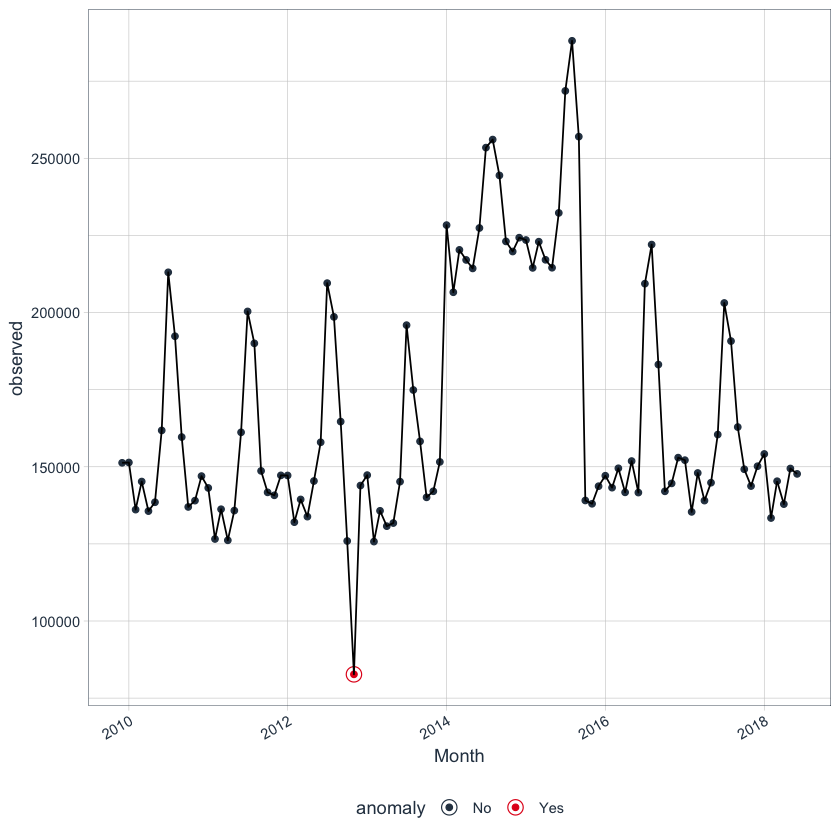

In [319]:
ts_anomalized_stl %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

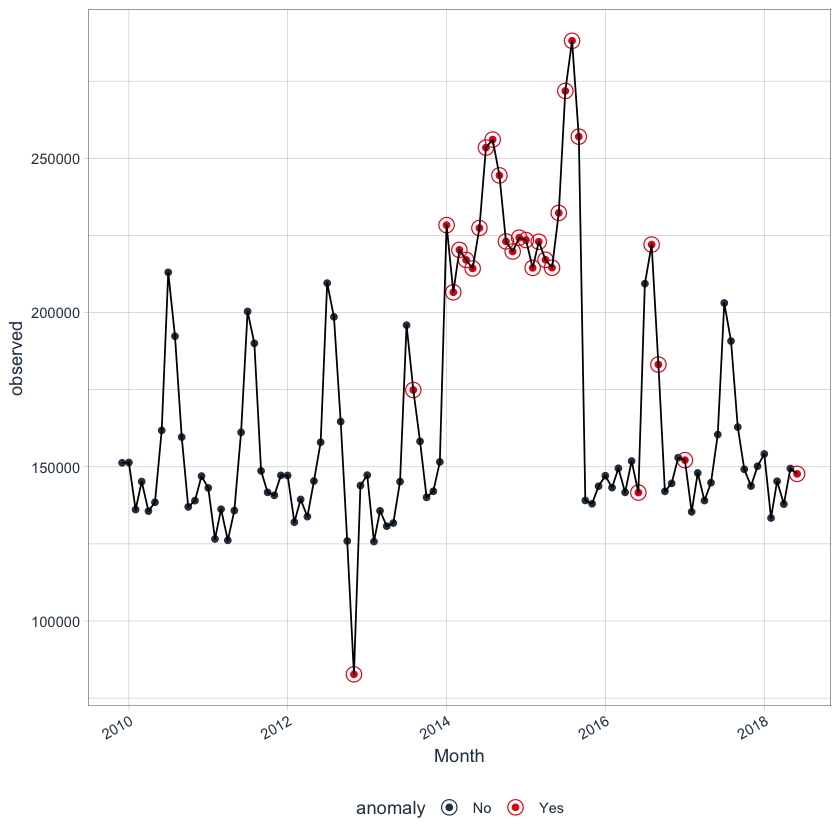

In [320]:
ts_anomalized_twitter %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

#### Level shift in the end
- neither method perform well
- need to apply the decomposition on the two levels separately

In [258]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

idx_outliers <- seq(50, length(ts))
ts$Imputed_KWH[idx_outliers] <- ts$Imputed_KWH[idx_outliers] + mean(ts$Imputed_KWH)/2

ts_anomalized_twitter <- ts %>%
    time_decompose(Imputed_KWH, method = "Twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

ts_anomalized_stl <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


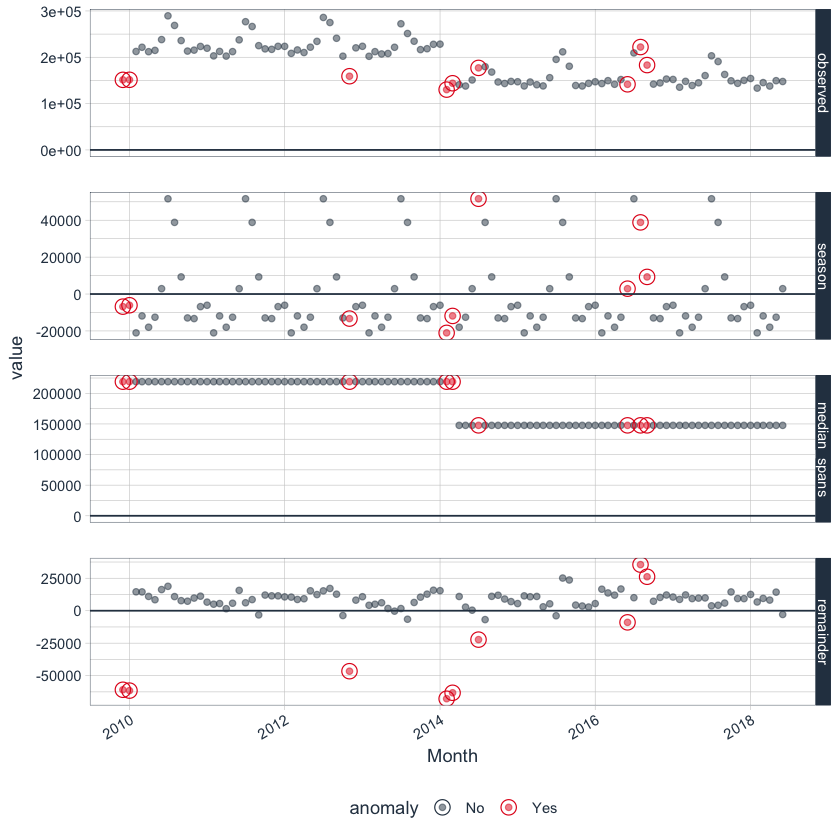

In [260]:
ts_anomalized_twitter %>%
    plot_anomaly_decomposition(alpha_dot = 0.5)

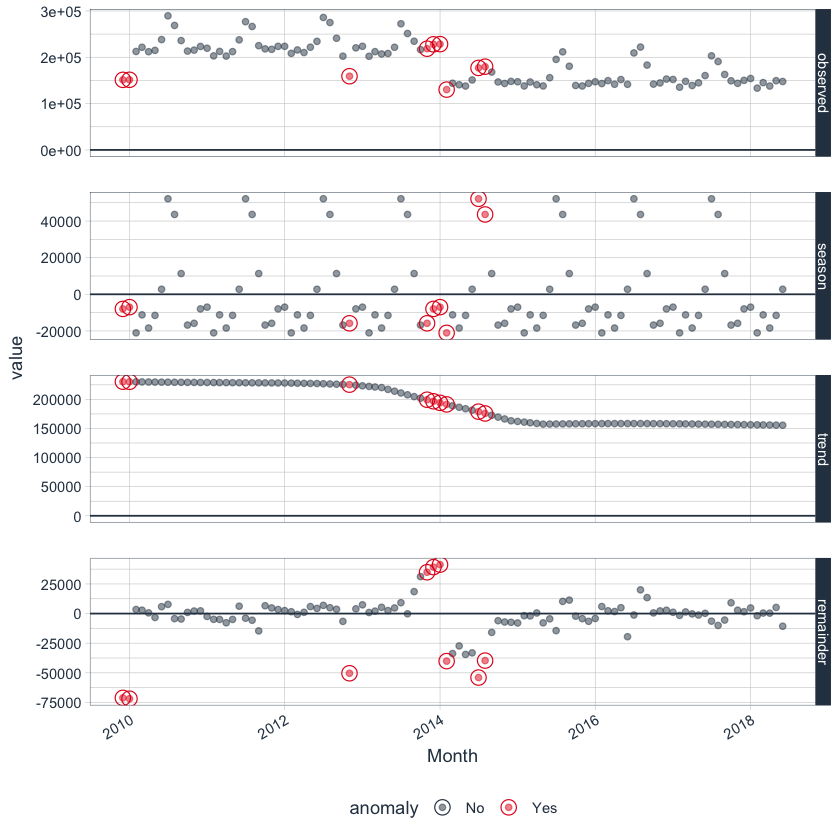

In [261]:
ts_anomalized_stl %>%
    plot_anomaly_decomposition(alpha_dot = 0.5)

## Testing the Anomalize package

#### Test 1 - Test the IQR test function (No issue)

In [238]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [239]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12265.34,150984.3,-56008.64,-23528,23388.25,Yes,115190.9,162107.2
165.0 - BLD 03_90327795,2014-07-01,177073.8,177073.8,49841.16,153031.5,-25798.86,-23528,23388.25,Yes,179344.6,226260.9
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,34686.26,156279.1,31064.60,-23528,23388.25,Yes,167437.4,214353.7


In [240]:
outliers <- iqr(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report


outliers

rank,index,value,limit_lower,limit_upper,outlier,direction
1,36,-56008.639,-23528,23388.25,Yes,Down
2,81,31064.598,-23528,23388.25,Yes,Up
3,56,-25798.860,-23528,23388.25,Yes,Down
4,69,21977.611,-23528,23388.25,No,NA
5,82,17759.188,-23528,23388.25,No,NA
6,70,16403.583,-23528,23388.25,No,NA
7,79,-16309.722,-23528,23388.25,No,NA
8,33,12769.406,-23528,23388.25,No,NA
9,35,-12572.417,-23528,23388.25,No,NA
10,22,-12412.488,-23528,23388.25,No,NA


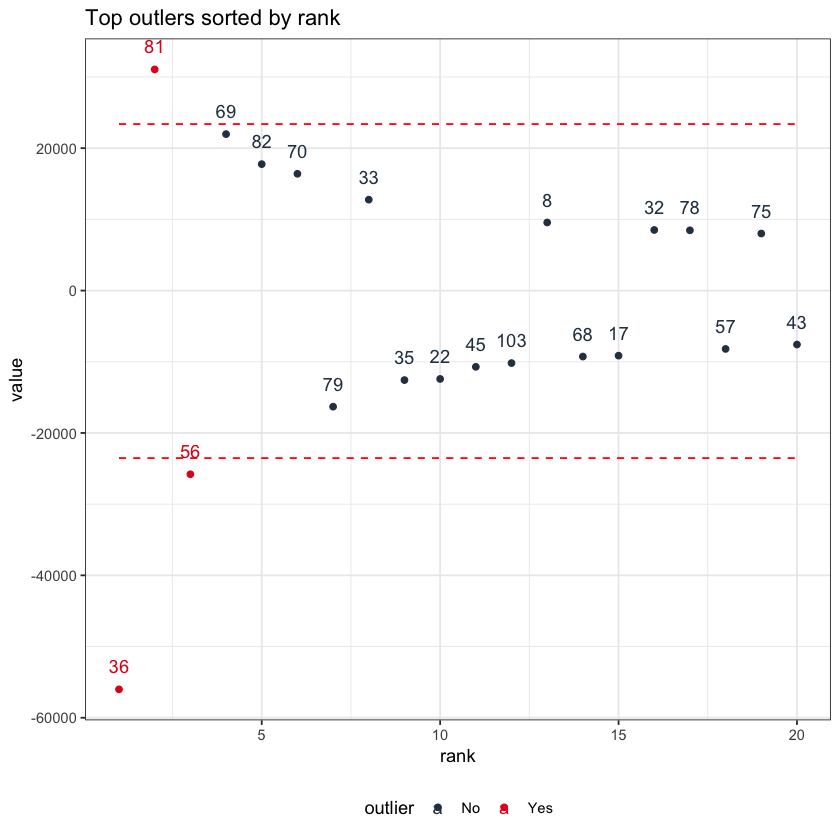

In [241]:
# ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

p4 <- outliers %>% 
    ggsetup() +
    ggtitle("Top outlers sorted by rank") 

p4

#### End of test 1

#### Test 2-  Test the GESD function
- remainder_l1, remainder_l2, recomposed_l1, recomposed_l2 values are incorrect in the time_recompose returned tibble (they should vary however in the ts_anomalize tibble they remain constant as the bounds for the first non-anomaly data point)
- some remainder values fall within its reminder range but were still labeled as an anomaly (when STL + GESD is applied)

In [371]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [372]:
ts_anomalized

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2009-12-01,151280.0,151280.0,-5292.352,154728.3,1844.0475,-16641.64,16641.64,No,132794.3,166077.6
165.0 - BLD 03_90327795,2010-01-01,151382.9,151382.9,-4686.829,154562.4,1507.2546,-16641.64,16641.64,No,133234.0,166517.2
165.0 - BLD 03_90327795,2010-02-01,136106.8,136106.8,-20499.522,154396.6,2209.7613,-16641.64,16641.64,No,117255.4,150538.7
165.0 - BLD 03_90327795,2010-03-01,145211.0,145211.0,-10309.362,154230.7,1289.6268,-16641.64,16641.64,No,127279.7,160563.0
165.0 - BLD 03_90327795,2010-04-01,135622.2,135622.2,-17242.700,154064.8,-1199.9609,-16641.64,16641.64,No,120180.5,153463.8
165.0 - BLD 03_90327795,2010-05-01,138498.6,138498.6,-12610.265,153898.9,-2790.1010,-16641.64,16641.64,No,124647.0,157930.3
165.0 - BLD 03_90327795,2010-06-01,161783.7,161783.7,1854.312,153764.6,6164.7718,-16641.64,16641.64,No,138977.3,172260.5
165.0 - BLD 03_90327795,2010-07-01,213036.4,213036.4,49841.165,153630.2,9564.9892,-16641.64,16641.64,No,186829.8,220113.0
165.0 - BLD 03_90327795,2010-08-01,192317.3,192317.3,34686.263,153495.9,4135.1997,-16641.64,16641.64,No,171540.5,204823.8
165.0 - BLD 03_90327795,2010-09-01,159626.5,159626.5,9046.662,153361.5,-2781.6960,-16641.64,16641.64,No,145766.5,179049.8


In [373]:
outliers <- anomalize::gesd(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report

In [374]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
165.0 - BLD 03_90327795,2012-11-01,82710.3,82710.3,-12265.344,150984.3,-56008.64,-16641.64,16641.64,Yes,122077.3,155360.6
165.0 - BLD 03_90327795,2014-07-01,177073.8,177073.8,49841.165,153031.5,-25798.86,-16641.64,16641.64,Yes,186231.0,219514.3
165.0 - BLD 03_90327795,2015-08-01,211696.2,211696.2,34686.263,155032.3,21977.61,-16641.64,16641.64,Yes,173076.9,206360.2
165.0 - BLD 03_90327795,2015-09-01,180635.5,180635.5,9046.662,155185.2,16403.58,-16641.64,16641.64,Yes,147590.3,180873.5
165.0 - BLD 03_90327795,2016-08-01,222030.0,222030.0,34686.263,156279.1,31064.60,-16641.64,16641.64,Yes,174323.8,207607.0
165.0 - BLD 03_90327795,2016-09-01,183134.8,183134.8,9046.662,156329.0,17759.19,-16641.64,16641.64,Yes,148734.0,182017.2


In [375]:
outliers

rank,index,value,limit_lower,limit_upper,outlier,direction
1,36,-56008.639,-17461.21,17461.21,Yes,Down
2,81,31064.598,-17367.90,17367.90,Yes,Up
3,56,-25798.860,-17418.77,17418.77,Yes,Down
4,69,21977.611,-17104.78,17104.78,Yes,Up
5,82,17759.188,-17302.82,17302.82,Yes,Up
6,70,16403.583,-16972.00,16972.00,Yes,NA
7,79,-16309.722,-16641.64,16641.64,No,NA
8,33,12769.406,-15899.38,15899.38,No,NA
9,35,-12572.417,-15180.87,15180.87,No,NA
10,22,-12412.488,-15018.01,15018.01,No,NA


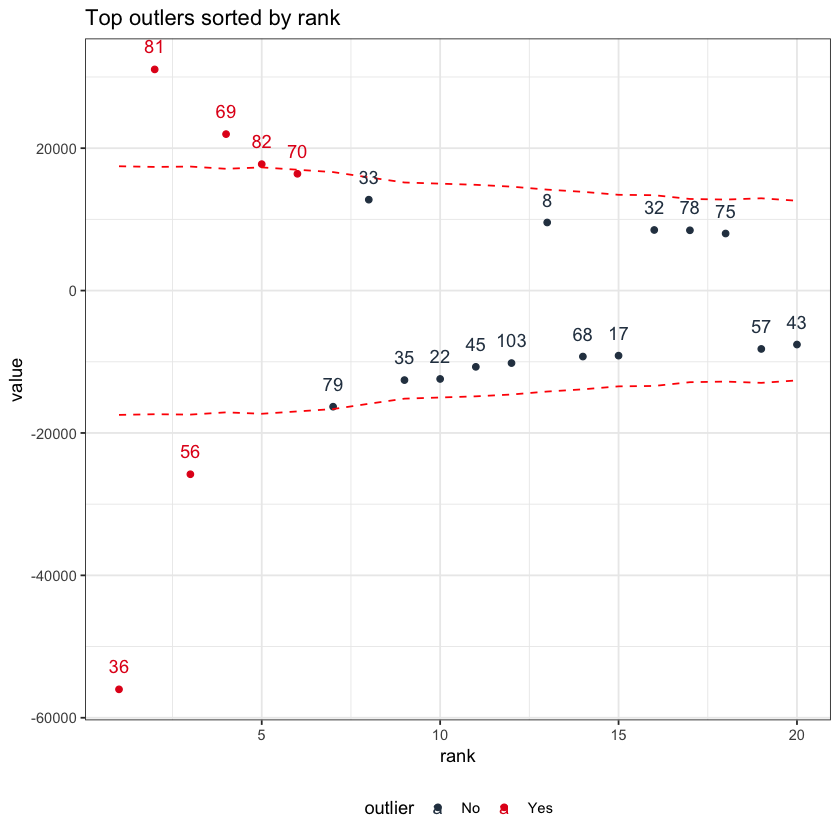

In [370]:
p4 <- outliers %>% 
    ggsetup() +
    ggtitle("Top outlers sorted by rank") 

p4

#### End of test2

## Conclusions
- The Twitter decomposition method works bettef when a long-term trend is less dominant that the short-term seasonal component.
- Check the characteristics of the time series to decide which decomposition algorithm to apply
- Perform level-change, variance-change detections before applying the decomposition algorithm